# Recipe Recommender System Model

This notebook presents the python code used to build a recipe recommender system based on BPR.

In [1]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import pylab as pl
%matplotlib inline

## Made-it interactions load

In [2]:
recipes = [f.path.split("/")[1] for f in os.scandir("recipe_data/") if f.is_dir() ]    

In [25]:
with open("data/user_data.json", "r") as in_file:
    users_data = json.load(in_file)

In [26]:
len(users_data.keys())

1017178

In [33]:
recipesDict = {}
for recipe in recipes:
    recipesDict[recipe] = True
    
userRecipes = {}
for user in users_data.keys():
    userRecipes[user] = list(filter(lambda x: str(x) in recipesDict, users_data[user]["made"]))

In [35]:
nb_interactions = 0
for user in userRecipes.keys():
    nb_interactions += len(userRecipes[user])
nb_interactions

4402092

In [36]:
recipeUsers = {}
for user in userRecipes.keys():
    for recipe in userRecipes[user]:
        if recipe in recipeUsers:
            recipeUsers[recipe].append(user)
        else:
            recipeUsers[recipe] = [user]

In [37]:
with open("data/madeUserRecipes.json", "w") as file:
    file.write(json.dumps(userRecipes))

with open("data/madeRecipeUsers.json", "w") as file:
    file.write(json.dumps(recipeUsers))

In [3]:
with open("data/madeUserRecipes.json", "r") as file:
    userRecipes = json.loads(file.read())

with open("data/madeRecipeUsers.json", "r") as file:
    recipeUsers = json.loads(file.read())

## Reviews interaction load

In [ ]:
recipes = [f.path.split("/")[1] for f in os.scandir("recipe_data/") if f.is_dir() ]    
print(recipes[:10])
print("Nb of recipes: " + str(len(recipes)))

In [3]:
def getAllUsersWithReviews(start_path, files):
    users = set()
    for file in files:
        try:
            with open(start_path + file + "/reviews.json") as data_file:    
                reviews = json.load(data_file)
                for review in reviews:
                    users.add(review["submitter"]["userID"])
        except: 
            print("Problem with file: " + file)
    return users

In [9]:
users = getAllUsersWithReviews("recipe_data/", recipes)

In [10]:
len(users)

1017178

In [11]:
userRecipes = {}
recipeUsers = {}

for user in users:
    userRecipes[user] = []

for recipe in recipes:
    recipeUsers[recipe] = []

for recipe in recipes:
    with open("recipe_data/" + recipe + "/reviews.json") as data_file:
        reviews = json.load(data_file)
        for review in reviews:
            user = review["submitter"]["userID"]
            userRecipes[user].append(recipe)
            recipeUsers[recipe].append(user)

In [12]:
with open("data/reviewUserRecipes.json", "w") as file:
    file.write(json.dumps(userRecipes))

with open("data/reviewRecipeUsers.json", "w") as file:
    file.write(json.dumps(recipeUsers))

In [2]:
with open("data/reviewUserRecipes.json", "r") as file:
    userRecipes = json.loads(file.read())

with open("data/reviewRecipeUsers.json", "r") as file:
    recipeUsers = json.loads(file.read())

## Interactions Analysis

In [4]:
users = list(userRecipes.keys())
recipes = list(recipeUsers.keys())

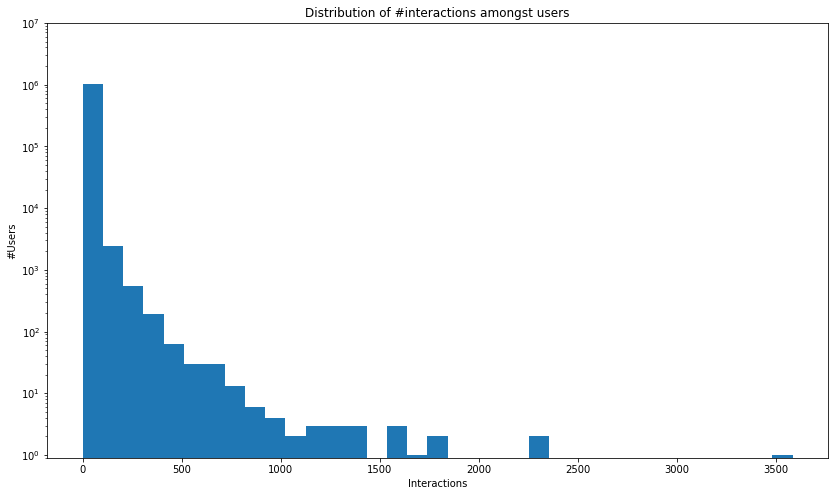

In [5]:
userDistrib = list(map(lambda x: len(userRecipes[x]), users))
fig = pl.gcf()
fig.set_size_inches(14, 8)
plt.hist(userDistrib, bins=35,log=True)
pl.title('Distribution of #interactions amongst users')
pl.xlabel('Interactions')
pl.ylabel('#Users')
font = {'family' : 'sans-serif',
        'size'   : 16}

axes = plt.gca()
axes.set_ylim([0.9,10**7])
matplotlib.rc('font', **font)
plt.show()

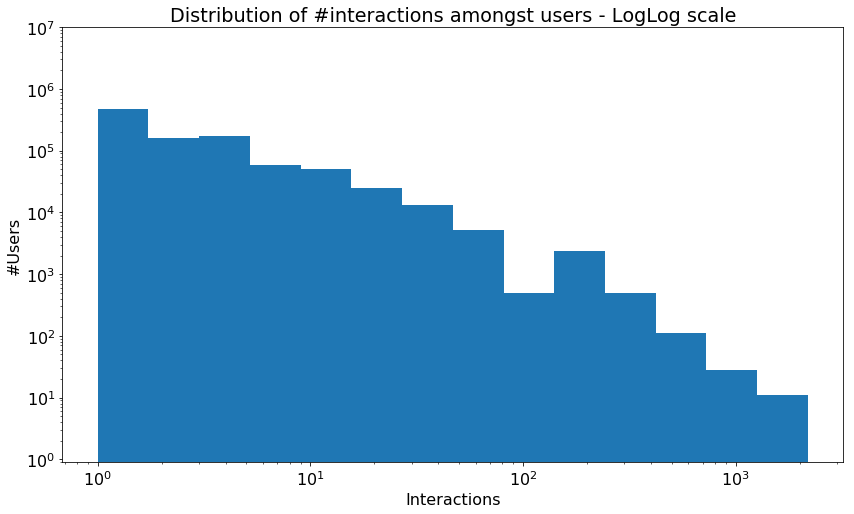

In [6]:
plt.hist(userDistrib, log=True, bins=np.sqrt(3)**(np.arange(0,15)))
fig = pl.gcf()
fig.set_size_inches(14, 8)
plt.xscale('log')

pl.title('Distribution of #interactions amongst users - LogLog scale')
pl.xlabel('Interactions')
pl.ylabel('#Users')

axes = plt.gca()
axes.set_ylim([0.9,10**7])
matplotlib.rc('font', **font)
plt.show()

In [7]:
pdUserDistrib = pd.DataFrame(userDistrib)
pdUserDistrib.columns = ["users interactions"]
pdUserDistrib.describe()

,users interactions
count,1.017178e+06
mean,4.327750e+00
std,1.627038e+01
min,0.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,3.000000e+00
max,3.584000e+03


In [8]:
for i in [3, 5, 10, 20, 50, 100]:
    print(str(len(pdUserDistrib[pdUserDistrib["users interactions"] >= i])) + " users with at least than " + str(i) + " interactions")

329077 users with at least than 3 interactions
191628 users with at least than 5 interactions
85931 users with at least than 10 interactions
34406 users with at least than 20 interactions
7870 users with at least than 50 interactions
3339 users with at least than 100 interactions


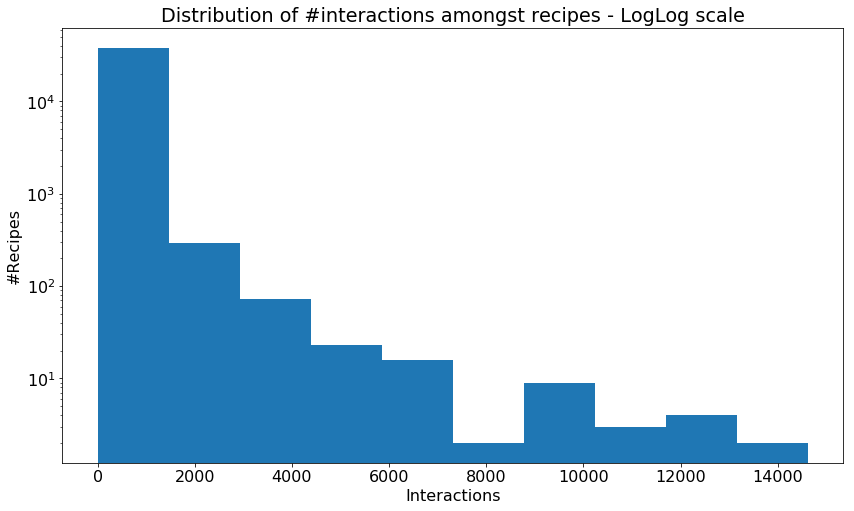

In [9]:
recipeDistrib = list(map(lambda x: len(recipeUsers[x]), recipes))
fig = pl.gcf()
pl.title('Distribution of #interactions amongst recipes - LogLog scale')
pl.xlabel('Interactions')
pl.ylabel('#Recipes')
fig.set_size_inches(14, 8)
plt.hist(recipeDistrib,  log=True)
plt.show()

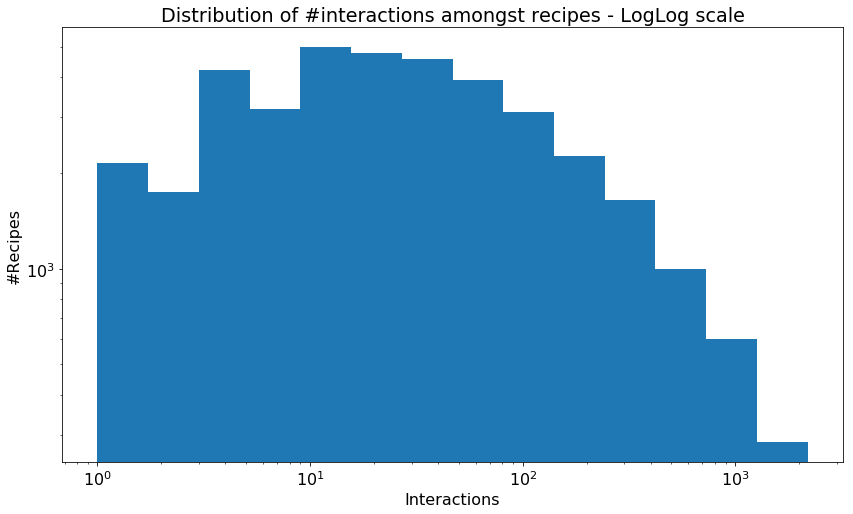

In [10]:
plt.hist(recipeDistrib, log=True, bins=np.sqrt(3)**(np.arange(0,15)))
fig = pl.gcf()
fig.set_size_inches(14, 8)
plt.xscale('log')

pl.title('Distribution of #interactions amongst recipes - LogLog scale')
pl.xlabel('Interactions')
pl.ylabel('#Recipes')

axes = plt.gca()
matplotlib.rc('font', **font)
plt.show()

In [11]:
pdrecipeDistrib = pd.DataFrame(recipeDistrib)
pdrecipeDistrib.columns = ["recipes interactions"]
pdrecipeDistrib.describe()

,recipes interactions
count,38677.000000
mean,113.816790
std,412.491537
min,1.000000
25%,7.000000
50%,22.000000
75%,74.000000
max,14620.000000


## Cleaning data


In [12]:
cleanedUserRecipes = {}
cleanedRecipeUsers = {}

for user, recipes in userRecipes.items():
    if len(recipes) >= 10 and len(recipes) < 200:
        cleanedUserRecipes[user] = recipes
        for recipe in recipes:
            if recipe in cleanedRecipeUsers.keys():
                cleanedRecipeUsers[recipe].extend([user])
            else:
                cleanedRecipeUsers[recipe] = [user]
        


In [13]:
# REMOVE POPULAR RECIPE
'''userRecipes = cleanedUserRecipes
recipeUsers = cleanedRecipeUsers
cleanedUserRecipes = {}
cleanedRecipeUsers = {}

for recipe, users in recipeUsers.items():
    if len(users) >= 10 and len(users) < 500:
        cleanedRecipeUsers[recipe] = users
        for user in users:
            if user in cleanedUserRecipes.keys():
                cleanedUserRecipes[user].extend([recipe])
            else:
                cleanedUserRecipes[user] = [recipe]
                '''

'userRecipes = cleanedUserRecipes\nrecipeUsers = cleanedRecipeUsers\ncleanedUserRecipes = {}\ncleanedRecipeUsers = {}\n\nfor recipe, users in recipeUsers.items():\n    if len(users) >= 10 and len(users) < 500:\n        cleanedRecipeUsers[recipe] = users\n        for user in users:\n            if user in cleanedUserRecipes.keys():\n                cleanedUserRecipes[user].extend([recipe])\n            else:\n                cleanedUserRecipes[user] = [recipe]\n                '

In [14]:
def cleanSmall(UserRecipes, RecipeUsers, threshold):
    
    cleaned = False
    while cleaned == False:
    
        nbUsers = len(UserRecipes.keys())
        nbRecipes = len(RecipeUsers.keys())

        print("Cleaning users and recipes with less than " + str(threshold) + " reviews")
        print("Number of users: "  + str(nbUsers))
        print("Number of recipes: "  + str(nbRecipes))

        toRemove = []
        for recipe, users in RecipeUsers.items():
            if len(users) < threshold:
                toRemove.extend([recipe])

        for recipe in toRemove:
            RecipeUsers.pop(recipe)

        UserRecipes = {}
        for recipe, users in RecipeUsers.items():
            for user in users:
                if user in UserRecipes.keys():
                    UserRecipes[user].extend([recipe])
                else:
                    UserRecipes[user] = [recipe]

        toRemove= []
        for user, recipes in UserRecipes.items():
            if len(recipes) < threshold:
                toRemove.extend([user])

        for user in toRemove:
            UserRecipes.pop(user) 

        RecipeUsers = {}
        for user, recipes in UserRecipes.items():
            for recipe in recipes:
                if recipe in RecipeUsers.keys():
                    RecipeUsers[recipe].extend([user])
                else:
                    RecipeUsers[recipe] = [user]   

        if len(UserRecipes.keys()) == nbUsers and len(RecipeUsers.keys()) == nbRecipes:
            cleaned = True
    return UserRecipes, RecipeUsers

In [15]:
userRecipes, recipeUsers = cleanSmall(cleanedUserRecipes, cleanedRecipeUsers, 10)

Cleaning users and recipes with less than 10 reviews
Number of users: 85019
Number of recipes: 34755
Cleaning users and recipes with less than 10 reviews
Number of users: 81823
Number of recipes: 18448
Cleaning users and recipes with less than 10 reviews
Number of users: 81740
Number of recipes: 18240
Cleaning users and recipes with less than 10 reviews
Number of users: 81735
Number of recipes: 18228


In [16]:
users = list(userRecipes.keys())
recipes = list(recipeUsers.keys())

In [17]:
min(map(lambda x: len(recipeUsers[x]), recipeUsers.keys()))

10

In [18]:
min(map(lambda x: len(userRecipes[x]), userRecipes.keys()))

10

In [19]:
nbUsers = len(userRecipes.keys())
nbRecipes = len(recipeUsers.keys())
print("Number of users: "  + str(nbUsers))
print("Number of recipes: "  + str(nbRecipes))

Number of users: 81735
Number of recipes: 18228


## Building Model

In [20]:
'''# Sample 1000 recipes and 10000 users for test
N = 1000
M = 10000

sampleRecipes = np.random.choice(list(recipes), N)
sampleUsers = []
while len(sampleUsers) < M:
    r = np.random.choice(sampleRecipes)
    if(len(recipeUsers[r]) > 1):
        u = np.random.choice(recipeUsers[r])
        if str(u) not in sampleUsers:
            sampleUsers.append(str(u))
            '''

'# Sample 1000 recipes and 10000 users for test\nN = 1000\nM = 10000\n\nsampleRecipes = np.random.choice(list(recipes), N)\nsampleUsers = []\nwhile len(sampleUsers) < M:\n    r = np.random.choice(sampleRecipes)\n    if(len(recipeUsers[r]) > 1):\n        u = np.random.choice(recipeUsers[r])\n        if str(u) not in sampleUsers:\n            sampleUsers.append(str(u))\n            '

In [21]:
  '''W = np.zeros((N,M))
for i in range(N):
    for j in range(M):
        if sampleRecipes[i] in userRecipes[sampleUsers[j]]:
            W[i,j] = 1  '''

'W = np.zeros((N,M))\nfor i in range(N):\n  for j in range(M):\n      if sampleRecipes[i] in userRecipes[sampleUsers[j]]:\n          W[i,j] = 1  '

In [22]:
  '''sampleInteractions = []

for user in sampleUsers:
    for recipe in sampleRecipes:
        if recipe in userRecipes[user]:
            sampleInteractions.append((recipe, user))  '''

'sampleInteractions = []\n\nfor user in sampleUsers:\n  for recipe in sampleRecipes:\n      if recipe in userRecipes[user]:\n          sampleInteractions.append((recipe, user))  '

In [23]:
interactions = []
for user in users:
    for recipe in userRecipes[user]:
        interactions.append((recipe, user))

#interactions = np.array(sampleInteractions)

## Export interactions

In [24]:
dfInteractions = pd.DataFrame(interactions)
dfInteractions.columns = ["item", "user"]
dfInteractions["item"] = pd.factorize(dfInteractions["item"])[0]
dfInteractions["user"] = pd.factorize(dfInteractions["user"])[0]

In [25]:
dfInteractions.to_csv("data/interactions.csv")

In [26]:
popInt = list(map(lambda x: len(recipeUsers[x[0]]), interactions))
sum(popInt) / len(popInt)

810.9966743914924

In [27]:
arr = np.array(interactions)
np.random.shuffle(arr)
test = {}
test_te = []

for i in range(len(arr)):
    user = arr[i][1]
    if user not in test:
        test_te.append(arr[i])
        test[user] = True

In [28]:
popInt = list(map(lambda x: len(recipeUsers[int(x[0])]), test_te))
sum(popInt) / len(popInt)

837.5526151587447

In [29]:
len(test_te)

81735

## Sample data

In [30]:
#interactions = np.random.choice(interactions, size = len(interactions)/10)

## Use sample instead of real values


In [31]:
'''recipes = sampleRecipes
users = sampleUsers
interactions = sampleInteractions  '''

'recipes = sampleRecipes\nusers = sampleUsers\ninteractions = sampleInteractions  '

## Model

In [32]:
userDict = {}
for i in range(len(users)):
    userDict[users[i]] = i
    
recipeDict = {}
for i in range(len(recipes)):
    recipeDict[recipes[i]] = i

In [33]:
def sample_neg_pop(interactions, user, userRecipes):
    interaction  = interactions[np.random.randint(0, len(interactions))]
    recipe = interaction[0]
    while recipe in userRecipes[user]:    
        interaction  = interactions[np.random.randint(0, len(interactions))]
        recipe = interaction[0]
    return recipe

In [34]:
def sample_neg(recipes, user, userRecipes):
    recipe  = recipes[np.random.randint(0, len(recipes))]
    while recipe in userRecipes[user]:
        recipe  = recipes[np.random.randint(0, len(recipes))]
    return recipe

In [35]:
# Split test-train 

userRecipes_tr = {}
recipeUsers_tr = {}
for interaction in interactions:
    r = interaction[0]
    u = interaction[1]
    if u not in userRecipes_tr.keys():
        userRecipes_tr[u] = [r]
    else:
        userRecipes_tr[u].append(r)
    if r not in recipeUsers_tr.keys():
        recipeUsers_tr[r] = [u]
    else:
        recipeUsers_tr[r].append(u)
        

interactions_te = []
userRecipes_te = {}
for user in userRecipes_tr.keys():
    test_recipe = np.random.choice(userRecipes_tr[user])
    userRecipes_tr[user].remove(test_recipe)
    recipeUsers_tr[test_recipe].remove(user)
    userRecipes_te[user] = test_recipe
    interactions_te.append((test_recipe, user))

interactions_tr = []
for user in userRecipes_tr.keys():
    for recipe in userRecipes_tr[user]:
        interactions_tr.append((recipe, user))

### Weight interactions inversely to popularity

In [36]:
# Returns an array with interactions replicated according to the inverse frequency of the recipe
# An interaction with the most popular recipe will be present only once in the array.
# This way, selecting a random interaction in the array will select recipes uniformly
def probWeightedInteractions(interactions, recipeUsers, power = 0):
    apps = np.zeros((len(interactions)))
    for i in range(len(interactions)):
        apps[i] = (len(recipeUsers[interactions[i][0]]))
    factor = max(apps)**(1 - power)
    weighted_inter =np.zeros((len(interactions)))
    for i in range(len(apps)):
        weighted_inter[i] = 1 / apps[i] * (apps[i]**power) * factor
        
    interactions_array = []
    for i in range(int(len(interactions))):
        for j in range(int(round(weighted_inter[i]))):
            interactions_array.append(interactions[i])
    return interactions_array

Let's check the effect of the method

In [37]:
from collections import Counter

def plotInteractionDistrib(interactions_list, legends = None):
    for i in range(len(interactions_list)): 
        interactions = interactions_list[i]
        recipes = list(map(lambda x: x[0], interactions))
        c = Counter(recipes)
        count = list(map(lambda x: c[x], c.keys()))
        count = sorted(count)
        if legends:
            plt.plot(count, label="x = " + str(legends[i]))
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        else:
            plt.plot(count)
    plt.show()

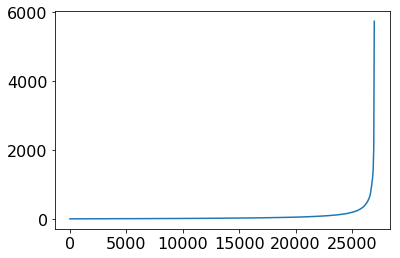

In [36]:
plotInteractionDistrib([interactions_tr])

In [37]:
powers = [1, 3/4, 1/2, 1/4, 0]
plotInteractionDistrib(list(map(lambda x: probWeightedInteractions(interactions_tr, recipeUsers, x), powers)), powers)

KeyboardInterrupt: 

In [ ]:
test = probWeightedInteractions(interactions_tr, recipeUsers, 1)

In [ ]:
len(test)

In [ ]:
len(interactions_tr)

## Run Bayesian Personalized Ranking

In [38]:
def BPR(interactions_tr, interactions_te, bias, alpha = 0.01, _lambda = 0.01, K = 30, P = None, Q = None, prob = False, power = 0, _iter = 25*10**6, _pop = False):
        
    print("BPR with K: " + str(K))

    aucs = []

    # Initialize low-rank matrices with random values
    if P is None or Q is None:
        sigma = 0.1; # std for random initialization
        mu = 0.0; # mean for random initialization
        N = len(users)
        M = len(recipes)
        P = ((np.random.rand(N,K) * 4) - 2) * sigma # Users
        Q = ((np.random.rand(K,M) * 4) - 2) * sigma # Recipes
    
    b = np.zeros(len(recipes))
    
    if(prob):
        interactions_tr = probWeightedInteractions(interactions_tr, recipeUsers, power)
        print("done")

    for step in range(_iter + 1):

        # Select a random positive example
        i  = interactions_tr[np.random.randint(0, len(interactions_tr))]
        recipe = i[0]
        user = i[1]
        ir = recipeDict[recipe]
        iu = userDict[user]

        # Sample a negative example
        if(_pop):
            ji = recipeDict[sample_neg_pop(interactions_tr, user, userRecipes_tr)]
        else:
            ji = recipeDict[sample_neg(recipes, user, userRecipes_tr)]

        # See BPR paper for details
        px = np.dot(P[iu,:], (Q[:,ir]-Q[:,ji]))
        if bias:
            px += (b[ir]-b[ji]) 
        z = 1 / (1 + np.exp(px))

        # update P
        d = (Q[:,ir]-Q[:,ji])*z - _lambda*P[iu,:].T
        P[iu,:] = P[iu,:] + alpha*d.T

        # update Q positive 
        d = P[iu,:]*z - _lambda*Q[:,ir].T
        Q[:,ir] = Q[:,ir] + alpha*d.T

        # update Q negative
        d = -P[iu,:]*z - _lambda*Q[:,ji].T
        Q[:,ji] = Q[:,ji] + alpha*d.T

        if bias:
            # neg
            d = -z - _lambda*b[ji]
            b[ji] = b[ji] + alpha*d

            # pos
            d = z - _lambda*b[ir]
            b[ir] = b[ir] + alpha*d

        if step % 500000 == 0:
            print("Computing AUC...")
            # Compute the Area Under the Curve (AUC)
            auc = 0
            auc_non_un = 0
            fails = []
            for interaction in interactions_te:
                recipe = interaction[0]
                user = interaction[1]
                
                
                
                n_recipe = sample_neg(recipes, user, userRecipes)
                
                ir = recipeDict[recipe]
                iu = userDict[user]
                ji = recipeDict[n_recipe]

                sp = np.dot(P[iu,:],Q[:,ir])
                sn = np.dot(P[iu,:],Q[:,ji])
                
                if bias:
                    sp += b[ir]
                    sn += b[ji]

                if sp > sn:
                    auc = auc+1
                else:
                    fails.append((recipe, n_recipe))
                    if sp == sn:
                        auc = auc+0.5
                        
                if prob:
                    n_recipe_non_un = sample_neg(interactions, user, userRecipes)[0]
                    ji_non_un = recipeDict[n_recipe_non_un]
                    sn_non_un = np.dot(P[iu,:],Q[:,ji_non_un])
                    
                    if bias:
                        sn_non_un += b[ji]
                    
                    if sp > sn_non_un:
                        auc_non_un = auc_non_un+1
                    else:
                        if sp == sn_non_un:
                            auc_non_un = auc_non_un+0.5

            auc = auc / len(userRecipes_te.keys())
            print("AUC test: " + str(auc))
            
            aucs.append(auc)
            
            if prob:
                auc_non_un = auc_non_un / len(userRecipes_te.keys())
                print("non-uniform AUC test: " + str(auc_non_un))
            
    return fails, aucs

In [57]:
mu = 0.0; # mean for random initialization
N = len(users)
M = len(recipes)
K = 30
sigma = 0.1; # std for random initialization
uFactors = ((np.random.rand(N,K) * 4) - 2) * sigma # Users
rFactors = ((np.random.rand(K,M) * 4) - 2) * sigma # Recipes

In [60]:
non_uni = BPR(interactions_tr, interactions_te, False, P=uFactors, Q=rFactors, alpha=0.01, _lambda=0.01, K=30, prob=False, _pop=True, _iter = 50*10**6)

BPR with K: 30
Computing AUC...
AUC test: 0.6696641585612039
Computing AUC...
AUC test: 0.6715850003058665
Computing AUC...
AUC test: 0.6699455557594666
Computing AUC...
AUC test: 0.671756285556983
Computing AUC...
AUC test: 0.6694072306845292
Computing AUC...
AUC test: 0.6696396892396158
Computing AUC...
AUC test: 0.6729797516363859
Computing AUC...
AUC test: 0.6732122101914725
Computing AUC...
AUC test: 0.6723435492750963
Computing AUC...
AUC test: 0.6729919862971799
Computing AUC...
AUC test: 0.6708998593014008
Computing AUC...
AUC test: 0.6706429314247262
Computing AUC...
AUC test: 0.6730409249403561
Computing AUC...
AUC test: 0.6730898635835322
Computing AUC...
AUC test: 0.6733100874778247
Computing AUC...
AUC test: 0.6737138312840276
Computing AUC...
AUC test: 0.672600477151771
Computing AUC...
AUC test: 0.6726494157949471
Computing AUC...
AUC test: 0.6733590261210008
Computing AUC...
AUC test: 0.6726616504557411
Computing AUC...
AUC test: 0.6726494157949471
Computing AUC...
AUC 

In [73]:
'''uFactorsCopy = uFactors * 1.0
rFactorsCopy = rFactors * 1.0'''
hybrid = BPR(interactions_tr, interactions_te, False, P=uFactors, Q=rFactors, alpha=0.01, _lambda=0.01, K=30, prob=False, _pop=False, _iter = 50*10**6)

BPR with K: 30
Computing AUC...
AUC test: 0.8277237413592708
Computing AUC...
AUC test: 0.8278705572887992
Computing AUC...
AUC test: 0.8265736832446321
Computing AUC...
AUC test: 0.8261699394384291
Computing AUC...
AUC test: 0.8283110050773842
Computing AUC...
AUC test: 0.8278093839848291
Computing AUC...
AUC test: 0.8292408392977305
Computing AUC...
AUC test: 0.82823759711262
Computing AUC...
AUC test: 0.8278460879672112
Computing AUC...
AUC test: 0.8301706735180767
Computing AUC...
AUC test: 0.829889276319814
Computing AUC...
AUC test: 0.8288982687954977
Computing AUC...
AUC test: 0.8282865357557961
Computing AUC...
AUC test: 0.8280173732183275
Computing AUC...
AUC test: 0.8293142472624947
Computing AUC...
AUC test: 0.8295956444607573
Computing AUC...
AUC test: 0.8304398360555454
Computing AUC...
AUC test: 0.8301951428396648
Computing AUC...
AUC test: 0.8307946412185722
Computing AUC...
AUC test: 0.8309047531657184
Computing AUC...
AUC test: 0.8305866519850738
Computing AUC...
AUC t

In [54]:
uFactorsSimple = ((np.random.rand(N,K) * 4) - 2) * sigma # Users
rFactorsSimple = ((np.random.rand(K,M) * 4) - 2) * sigma # Recipes'''
simple = BPR(interactions_tr, interactions_te, False, P=uFactorsSimple, Q=rFactorsSimple, alpha=0.05, _lambda=0.01, K=30, prob=False, _pop=False, _iter = 50*10**6)

BPR with K: 30
Computing AUC...
AUC test: 0.5036275769254297
Computing AUC...
AUC test: 0.5029791399033462
Computing AUC...
AUC test: 0.5056340612956506
Computing AUC...
AUC test: 0.5287820395179543
Computing AUC...
AUC test: 0.5998776533920597
Computing AUC...
AUC test: 0.6928977794090658
Computing AUC...
AUC test: 0.7529454945861626
Computing AUC...
AUC test: 0.7911665749067107
Computing AUC...
AUC test: 0.809530800758549
Computing AUC...
AUC test: 0.8196366305744174
Computing AUC...
AUC test: 0.8269040190860708
Computing AUC...
AUC test: 0.8296568177647274
Computing AUC...
AUC test: 0.8305499480026917
Computing AUC...
AUC test: 0.8374135927081422
Computing AUC...
AUC test: 0.8347953752982199
Computing AUC...
AUC test: 0.8350155991925123
Computing AUC...
AUC test: 0.8359331987520646
Computing AUC...
AUC test: 0.836104484003181
Computing AUC...
AUC test: 0.8386370587875451
Computing AUC...
AUC test: 0.8385391815011929
Computing AUC...
AUC test: 0.840239799351563
Computing AUC...
AUC t

In [56]:
bias = BPR(interactions_tr, interactions_te, True, alpha=0.02, _lambda=0.01, K=30, prob=False, _pop=False, _iter = 50*10**6)

BPR with K: 30
Computing AUC...
AUC test: 0.5000917599559552
Computing AUC...
AUC test: 0.8235394873677128
Computing AUC...
AUC test: 0.8312840276503334
Computing AUC...
AUC test: 0.8365082278093839
Computing AUC...
AUC test: 0.836911971615587
Computing AUC...
AUC test: 0.8381599070165779
Computing AUC...
AUC test: 0.839420077078363
Computing AUC...
AUC test: 0.839420077078363
Computing AUC...
AUC test: 0.8397504129198018
Computing AUC...
AUC test: 0.8390897412369243
Computing AUC...
AUC test: 0.8396892396158316
Computing AUC...
AUC test: 0.8399584021533003
Computing AUC...
AUC test: 0.8393589037743928
Computing AUC...
AUC test: 0.8400195754572705
Computing AUC...
AUC test: 0.8401908607083869
Computing AUC...
AUC test: 0.8416712546644645
Computing AUC...
AUC test: 0.841952651862727
Computing AUC...
AUC test: 0.8417936012724048
Computing AUC...
AUC test: 0.8422218144001957
Computing AUC...
AUC test: 0.8400807487612406
Computing AUC...
AUC test: 0.8418058359331988
Computing AUC...
AUC te

In [308]:
sigma = 0.1; # std for random initialization
mu = 0.0; # mean for random initialization
K = 30
N = len(users)
M = len(recipes)
P = ((np.random.rand(N,K) * 4) - 2) * sigma # Users
Q = ((np.random.rand(K,M) * 4) - 2) * sigma # Recipes

In [309]:
normalfails = BPR(interactions_tr, interactions_te, True, 0.01, 30, prob=False)[0]

BPR with K: 30
Computing AUC...
AUC test: 0.503688372339861
Computing AUC...
AUC test: 0.713103009074988
Computing AUC...
AUC test: 0.7357816342054521
Computing AUC...
AUC test: 0.7418846963505458
Computing AUC...
AUC test: 0.7449450724406942
Computing AUC...
AUC test: 0.7470501866298714
Computing AUC...
AUC test: 0.74899609050222
Computing AUC...
AUC test: 0.7502520830016451
Computing AUC...
AUC test: 0.7496506218047374
Computing AUC...
AUC test: 0.7483946293053123
Computing AUC...
AUC test: 0.7514903854658671
Computing AUC...
AUC test: 0.7515434555714766
Computing AUC...
AUC test: 0.7512073449026163
Computing AUC...
AUC test: 0.7503936032832705
Computing AUC...
AUC test: 0.7521449167683844
Computing AUC...
AUC test: 0.7535247395142316
Computing AUC...
AUC test: 0.7527817580356985
Computing AUC...
AUC test: 0.7491553008190486
Computing AUC...
AUC test: 0.7508889242689593
Computing AUC...
AUC test: 0.7507827840577402
Computing AUC...
AUC test: 0.7531886288453714
Computing AUC...
AUC te

In [312]:
nobiasnormalfails = BPR(interactions_tr, interactions_te, False, 0.01, 30, prob=False, _iter = 50*10**6)[0]

BPR with K: 30
Computing AUC...
AUC test: 0.49868209237736383
Computing AUC...
AUC test: 0.49946045392630334
Computing AUC...
AUC test: 0.5025385200516549
Computing AUC...
AUC test: 0.4996550443135382
Computing AUC...
AUC test: 0.4998319446655699
Computing AUC...
AUC test: 0.4984167418493163
Computing AUC...
AUC test: 0.5000972951936175
Computing AUC...
AUC test: 0.49767376037078315
Computing AUC...
AUC test: 0.4996019742079287
Computing AUC...
AUC test: 0.5003980257920714
Computing AUC...
AUC test: 0.5000265350528048
Computing AUC...
AUC test: 0.5022731695236073
Computing AUC...
AUC test: 0.500981796953776
Computing AUC...
AUC test: 0.4985405720957385
Computing AUC...
AUC test: 0.5009994869889791
Computing AUC...
AUC test: 0.5000619151232111
Computing AUC...
AUC test: 0.5008402766721506
Computing AUC...
AUC test: 0.5002741955456491
Computing AUC...
AUC test: 0.49868209237736383
Computing AUC...
AUC test: 0.5059350068106635
Computing AUC...
AUC test: 0.5012117674114172
Computing AUC...

In [313]:
nobiasnormal_0_75_fails = BPR(interactions_tr, interactions_te, False, 0.01, 30, prob=True, power=0.75, _iter = 100*10**6)[0]

BPR with K: 30
done
Computing AUC...
AUC test: 0.497868350758018
Computing AUC...
AUC test: 0.5011763873410108
Computing AUC...
AUC test: 0.5009994869889791
Computing AUC...
AUC test: 0.49942507385589696
Computing AUC...
AUC test: 0.49648852801217075
Computing AUC...
AUC test: 0.5030338410373436
Computing AUC...
AUC test: 0.5015655681154806
Computing AUC...
AUC test: 0.4990358930814272
Computing AUC...
AUC test: 0.5006103062145094
Computing AUC...
AUC test: 0.5003272656512586
Computing AUC...
AUC test: 0.5038829627270959
Computing AUC...
AUC test: 0.4998142546303667
Computing AUC...
AUC test: 0.5001857453696333
Computing AUC...
AUC test: 0.4990889631870367
Computing AUC...
AUC test: 0.5039714129031116
Computing AUC...
AUC test: 0.49951352403191285
Computing AUC...
AUC test: 0.5010171770241822
Computing AUC...
AUC test: 0.5041836933255497
Computing AUC...
AUC test: 0.5014948079746678
Computing AUC...
AUC test: 0.5052450954377399
Computing AUC...
AUC test: 0.5002918855808524
Computing AU

AUC test: 0.6929363689433742
Computing AUC...
AUC test: 0.6904066939093209
Computing AUC...
AUC test: 0.6923349077464664
Computing AUC...
AUC test: 0.6924233579224822
Computing AUC...
AUC test: 0.6952537635549895
Computing AUC...
AUC test: 0.6901236533460702
Computing AUC...
AUC test: 0.6945638521820658
Computing AUC...
AUC test: 0.6951653133789736
Computing AUC...
AUC test: 0.694687682428488
Computing AUC...
AUC test: 0.6941216013019866
Computing AUC...
AUC test: 0.6955898742238497
Computing AUC...
AUC test: 0.6937854906331263
Computing AUC...
AUC test: 0.6949530329565355
Computing AUC...
AUC test: 0.692918678908171
Computing AUC...
AUC test: 0.6949176528861293
Computing AUC...
AUC test: 0.6928302287321552
Computing AUC...
AUC test: 0.6965805161952272
Computing AUC...
AUC test: 0.6975888482018079
Computing AUC...
AUC test: 0.6968812467936811
Computing AUC...
AUC test: 0.6973411877089636
Computing AUC...
AUC test: 0.6982787595747315
Computing AUC...
AUC test: 0.6972704275681508
Computi

In [314]:
nobiasnormal_0_875_fails = BPR(interactions_tr, interactions_te, False, 0.01, 30, prob=True, power=0.875, _iter = 100*10**6)[0]

BPR with K: 30
done
Computing AUC...
AUC test: 0.5004157158272745
Computing AUC...
AUC test: 0.4997611845247572
Computing AUC...
AUC test: 0.5028392506501088
Computing AUC...
AUC test: 0.5011410072706045
Computing AUC...
AUC test: 0.5001857453696333
Computing AUC...
AUC test: 0.5042367634311592
Computing AUC...
AUC test: 0.5019016787843408
Computing AUC...
AUC test: 0.5027331104388898
Computing AUC...
AUC test: 0.5024146898052327
Computing AUC...
AUC test: 0.5044313538183941
Computing AUC...
AUC test: 0.5053866157193653
Computing AUC...
AUC test: 0.5019901289603567
Computing AUC...
AUC test: 0.5037414424454705
Computing AUC...
AUC test: 0.5036176121990483
Computing AUC...
AUC test: 0.5037414424454705
Computing AUC...
AUC test: 0.5018309186435281
Computing AUC...
AUC test: 0.5019370588547472
Computing AUC...
AUC test: 0.5004334058624776
Computing AUC...
AUC test: 0.5022024093827947
Computing AUC...
AUC test: 0.5016540182914964
Computing AUC...
AUC test: 0.5079693608590281
Computing AUC.

KeyboardInterrupt: 

# Grid search


In [363]:
ks = [30, 50, 70]
lambdas = [0.01, 0.025, 0.05]

results = []
i = 0

for k in ks:
    results.append([])
    for _lambda in lambdas:
        results[i].append(BPR(interactions_tr, interactions_te, False, 0.01, K = k, _lambda = _lambda, prob=True, power=0.875, _iter = 50*10**6))
    i += 1

BPR with K: 30
done
Computing AUC...
AUC test: 0.5007846963013234
Computing AUC...
AUC test: 0.4983987953851374
Computing AUC...
AUC test: 0.5005302002035968
Computing AUC...
AUC test: 0.4996712758737699
Computing AUC...
AUC test: 0.498812351543943
Computing AUC...
AUC test: 0.5002863081099423
Computing AUC...
AUC test: 0.5004559721750933
Computing AUC...
AUC test: 0.5007104682728198
Computing AUC...
AUC test: 0.5005832202239565
Computing AUC...
AUC test: 0.5017284526637258
Computing AUC...
AUC test: 0.5007422802850356
Computing AUC...
AUC test: 0.5000424160162877
Computing AUC...
AUC test: 0.5012936884967764
Computing AUC...
AUC test: 0.49896080760095013
Computing AUC...
AUC test: 0.5027676450627757
Computing AUC...
AUC test: 0.5034038853070919
Computing AUC...
AUC test: 0.5002969121140143
Computing AUC...
AUC test: 0.501876908720733
Computing AUC...
AUC test: 0.5018026806922293
Computing AUC...
AUC test: 0.501686036647438
Computing AUC...
AUC test: 0.5015799966067187
Computing AUC...

Computing AUC...
AUC test: 0.7992980149304377
Computing AUC...
AUC test: 0.7999554631828979
Computing AUC...
AUC test: 0.8034759925347811
Computing AUC...
AUC test: 0.805193841194435
Computing AUC...
AUC test: 0.8049287410926366
Computing AUC...
AUC test: 0.8062754496097726
Computing AUC...
AUC test: 0.809117322701052
Computing AUC...
AUC test: 0.8084386664404479
Computing AUC...
AUC test: 0.8094142348150661
Computing AUC...
AUC test: 0.8104110111978283
Computing AUC...
AUC test: 0.8116622836783169
Computing AUC...
AUC test: 0.8122030878859857
Computing AUC...
AUC test: 0.813348320325755
Computing AUC...
AUC test: 0.8116728876823889
Computing AUC...
AUC test: 0.8145677807940278
Computing AUC...
AUC test: 0.8167416016287751
Computing AUC...
AUC test: 0.8154903291482863
Computing AUC...
AUC test: 0.8170067017305734
Computing AUC...
AUC test: 0.8168900576857822
Computing AUC...
AUC test: 0.8169006616898541
Computing AUC...
AUC test: 0.8163280454699695
Computing AUC...
AUC test: 0.81885179

Computing AUC...
AUC test: 0.7097790125551409
Computing AUC...
AUC test: 0.7170321513403461
Computing AUC...
AUC test: 0.7237020699015948
Computing AUC...
AUC test: 0.7302129284017645
Computing AUC...
AUC test: 0.7380280794027825
Computing AUC...
AUC test: 0.7428741092636579
Computing AUC...
AUC test: 0.7478473871733967
Computing AUC...
AUC test: 0.7549838819138106
Computing AUC...
AUC test: 0.7585786392941974
Computing AUC...
AUC test: 0.7632231930777061
Computing AUC...
AUC test: 0.7657999660671869
Computing AUC...
AUC test: 0.769543179504581
Computing AUC...
AUC test: 0.7758949779436716
Computing AUC...
AUC test: 0.7794791313199865
Computing AUC...
AUC test: 0.7816529521547336
Computing AUC...
AUC test: 0.78294664065151
Computing AUC...
AUC test: 0.7862550899219545
Computing AUC...
AUC test: 0.788386494740414
Computing AUC...
AUC test: 0.7911965558194775
Computing AUC...
AUC test: 0.7942823210044113
Computing AUC...
AUC test: 0.7945156090939939
Computing AUC...
AUC test: 0.797315066

Computing AUC...
AUC test: 0.5055140821174076
Computing AUC...
AUC test: 0.5073379708177808
Computing AUC...
AUC test: 0.5081756871394638
Computing AUC...
AUC test: 0.5109433322022395
Computing AUC...
AUC test: 0.5123006447234476
Computing AUC...
AUC test: 0.5107842721411605
Computing AUC...
AUC test: 0.5154924499491008
Computing AUC...
AUC test: 0.5175602307431286
Computing AUC...
AUC test: 0.5189811672887682
Computing AUC...
AUC test: 0.5222790125551409
Computing AUC...
AUC test: 0.5256616898540889
Computing AUC...
AUC test: 0.5274749745503903
Computing AUC...
AUC test: 0.5313984560570071
Computing AUC...
AUC test: 0.5341979131319986
Computing AUC...
AUC test: 0.5384183067526298
Computing AUC...
AUC test: 0.5471878181201222
Computing AUC...
AUC test: 0.5530200203596878
Computing AUC...
AUC test: 0.555363505259586
Computing AUC...
AUC test: 0.5583644384119444
Computing AUC...
AUC test: 0.5671763657957245
Computing AUC...
AUC test: 0.5714391754326433
Computing AUC...
AUC test: 0.577494

Computing AUC...
AUC test: 0.49888657957244653
Computing AUC...
AUC test: 0.49925771971496435
Computing AUC...
AUC test: 0.5020571767899559
Computing AUC...
AUC test: 0.5030857651849339
Computing AUC...
AUC test: 0.5008801323379708
Computing AUC...
AUC test: 0.5005832202239565
Computing AUC...
AUC test: 0.5005726162198846
Computing AUC...
AUC test: 0.5025555649813369
Computing AUC...
AUC test: 0.4993531557516118
Computing AUC...
AUC test: 0.5008271123176111
Computing AUC...
AUC test: 0.4982609433322022
Computing AUC...
AUC test: 0.5024601289446895
Computing AUC...
AUC test: 0.5032766372582287
Computing AUC...
AUC test: 0.5035523413640991
Computing AUC...
AUC test: 0.5021738208347472
Computing AUC...
AUC test: 0.5043264336613505
Computing AUC...
AUC test: 0.5029903291482863
Computing AUC...
AUC test: 0.5033402612826603
Computing AUC...
AUC test: 0.5051641499830336
Computing AUC...
AUC test: 0.5041567695961995
Computing AUC...
AUC test: 0.504750593824228
Computing AUC...
AUC test: 0.5051

AUC test: 0.7905391075670173
Computing AUC...
AUC test: 0.791270783847981
Computing AUC...
AUC test: 0.7938263488293179
Computing AUC...
AUC test: 0.7984178825924669
Computing AUC...
AUC test: 0.7980467424499491
Computing AUC...
AUC test: 0.800602307431286
Computing AUC...
AUC test: 0.8033805564981337
Computing AUC...
AUC test: 0.8032214964370546
Computing AUC...
AUC test: 0.8072086019681032
Computing AUC...
AUC test: 0.8049393450967085
Computing AUC...
AUC test: 0.8071131659314558
Computing AUC...
AUC test: 0.8115244316253818
Computing AUC...
AUC test: 0.8112805395317272
Computing AUC...
AUC test: 0.8114183915846623
Computing AUC...
AUC test: 0.8124151679674245
Computing AUC...
AUC test: 0.8117789277231082
Computing AUC...
AUC test: 0.8147692568713947
Computing AUC...
AUC test: 0.8152676450627757
Computing AUC...
AUC test: 0.8143875127248049


In [365]:
i = 0
for k in ks:
    j = 0
    for _lambda in lambdas:
        print("With k = " + str(k) + " and lambda = " + ('%.3f' % _lambda) + ": AUC = " + ('%.6f' % results[i][j][1]) )
        j+=1
    i+=1

With k = 30 and lambda = 0.010: AUC = 0.816996
With k = 30 and lambda = 0.025: AUC = 0.818067
With k = 30 and lambda = 0.050: AUC = 0.813985
With k = 50 and lambda = 0.010: AUC = 0.815045
With k = 50 and lambda = 0.025: AUC = 0.817717
With k = 50 and lambda = 0.050: AUC = 0.816689
With k = 70 and lambda = 0.010: AUC = 0.813465
With k = 70 and lambda = 0.025: AUC = 0.815618
With k = 70 and lambda = 0.050: AUC = 0.814388


In [320]:
ks = [30, 50, 70]
lambdas = [0.004, 0.01, 0.03]

res = []
i = 0

for k in ks:
    res.append([])
    for _lambda in lambdas:
        res[i].append(BPR(interactions_tr, interactions_te, False, 0.01, K = k, _lambda = _lambda, prob=True, power=0.875, _iter = 50*10**6))
    i += 1

BPR with K: 30
done
Computing AUC...
AUC test: 0.5021139592067788
Computing AUC...
AUC test: 0.5012648375170267
Computing AUC...
AUC test: 0.49997346494719525
Computing AUC...
AUC test: 0.5003803357568681
Computing AUC...
AUC test: 0.4989828229758177
Computing AUC...
AUC test: 0.5010525570945886
Computing AUC...
AUC test: 0.5007518264961347
Computing AUC...
AUC test: 0.4991243432574431
Computing AUC...
AUC test: 0.499743494489554
Computing AUC...
AUC test: 0.5014240478338552
Computing AUC...
AUC test: 0.49979656459516353
Computing AUC...
AUC test: 0.5012471474818235
Computing AUC...
AUC test: 0.500150365299227
Computing AUC...
AUC test: 0.4990889631870367
Computing AUC...
AUC test: 0.49765607033557996
Computing AUC...
AUC test: 0.5034230218118134
Computing AUC...
AUC test: 0.500362645721665
Computing AUC...
AUC test: 0.500574926144103
Computing AUC...
AUC test: 0.5006456862849157
Computing AUC...
AUC test: 0.5037591324806736
Computing AUC...
AUC test: 0.5004510958976809
Computing AUC..

Computing AUC...
AUC test: 0.679916503033841
Computing AUC...
AUC test: 0.684392081940243
Computing AUC...
AUC test: 0.6877354985936422
Computing AUC...
AUC test: 0.6875585982416105
Computing AUC...
AUC test: 0.6899998230996479
Computing AUC...
AUC test: 0.6906543544021653
Computing AUC...
AUC test: 0.6932724796122345
Computing AUC...
AUC test: 0.6938562507739391
Computing AUC...
AUC test: 0.6964036158431955
Computing AUC...
AUC test: 0.6978188186594492
Computing AUC...
AUC test: 0.7002246634470802
Computing AUC...
AUC test: 0.7019405968617878
Computing AUC...
AUC test: 0.7009676449256134
Computing AUC...
AUC test: 0.7052132533743742
Computing AUC...
AUC test: 0.7040634010861682
Computing AUC...
AUC test: 0.7042403014381998
Computing AUC...
AUC test: 0.7034796299244636
Computing AUC...
AUC test: 0.7050540430575457
Computing AUC...
AUC test: 0.706433865803393
Computing AUC...
AUC test: 0.7079728988660687
Computing AUC...
AUC test: 0.709671142245573
Computing AUC...
AUC test: 0.706345415

Computing AUC...
AUC test: 0.5804985051920253
Computing AUC...
AUC test: 0.5886889914910931
Computing AUC...
AUC test: 0.5921031682853048
Computing AUC...
AUC test: 0.5955881052203293
Computing AUC...
AUC test: 0.6046807833147588
Computing AUC...
AUC test: 0.60563604521573
Computing AUC...
AUC test: 0.6131012400714677
Computing AUC...
AUC test: 0.6166746271825081
Computing AUC...
AUC test: 0.618850501512498
Computing AUC...
AUC test: 0.623626811017354
Computing AUC...
AUC test: 0.6287038511206637
Computing AUC...
AUC test: 0.6367351271029029
Computing AUC...
AUC test: 0.6366997470324965
Computing AUC...
AUC test: 0.6381857099895629
Computing AUC...
AUC test: 0.644129561817828
Computing AUC...
AUC test: 0.6463761962886306
Computing AUC...
AUC test: 0.6489412513930902
Computing AUC...
AUC test: 0.6534345203346955
Computing AUC...
AUC test: 0.6548851032213554
Computing AUC...
AUC test: 0.6578393391002848
Computing AUC...
AUC test: 0.6612181358240903
Computing AUC...
AUC test: 0.6608466450

Computing AUC...
AUC test: 0.5043429036423782
Computing AUC...
AUC test: 0.5077217003661837
Computing AUC...
AUC test: 0.5078278405774027
Computing AUC...
AUC test: 0.5101275451538149
Computing AUC...
AUC test: 0.5045374940296131
Computing AUC...
AUC test: 0.5109059067027544
Computing AUC...
AUC test: 0.5106228661395036
Computing AUC...
AUC test: 0.5115250579348652
Computing AUC...
AUC test: 0.5178757805728034
Computing AUC...
AUC test: 0.515239965327531
Computing AUC...
AUC test: 0.5195209538466982
Computing AUC...
AUC test: 0.5194325036706823
Computing AUC...
AUC test: 0.5244387836331794
Computing AUC...
AUC test: 0.5269330785968264
Computing AUC...
AUC test: 0.526579277892763
Computing AUC...
AUC test: 0.5298342443701463
Computing AUC...
AUC test: 0.5313909674680253
Computing AUC...
AUC test: 0.5330715208123264
Computing AUC...
AUC test: 0.5400413946823754
Computing AUC...
AUC test: 0.5454014753489359
Computing AUC...
AUC test: 0.5452599550673106
Computing AUC...
AUC test: 0.5519644

Computing AUC...
AUC test: 0.5019370588547472
Computing AUC...
AUC test: 0.5018486086787313
Computing AUC...
AUC test: 0.5002034354048365
Computing AUC...
AUC test: 0.49823984149728456
Computing AUC...
AUC test: 0.5035468520582356
Computing AUC...
AUC test: 0.49590475685046614
Computing AUC...
AUC test: 0.4986467123069575
Computing AUC...
AUC test: 0.5003803357568681
Computing AUC...
AUC test: 0.5005395460736967
Computing AUC...
AUC test: 0.5043782837127846
Computing AUC...
AUC test: 0.5012825275522298
Computing AUC...
AUC test: 0.5023969997700295
Computing AUC...
AUC test: 0.5010702471297918
Computing AUC...
AUC test: 0.5036176121990483
Computing AUC...
AUC test: 0.4979214208636275
Computing AUC...
AUC test: 0.49992039484158574
Computing AUC...
AUC test: 0.5022554794884042
Computing AUC...
AUC test: 0.5020255090307629
Computing AUC...
AUC test: 0.5048736046984733
Computing AUC...
AUC test: 0.5022200994179978
Computing AUC...
AUC test: 0.5032284314245785
Computing AUC...
AUC test: 0.50

Computing AUC...
AUC test: 0.692494118063295
Computing AUC...
AUC test: 0.6997293424613915
Computing AUC...
AUC test: 0.7020290470378036
Computing AUC...
AUC test: 0.7026128181995083
Computing AUC...
AUC test: 0.7052309434095774
Computing AUC...
AUC test: 0.7053724636912028
Computing AUC...
AUC test: 0.7089812308726494
Computing AUC...
AUC test: 0.7080613490420846
Computing AUC...
AUC test: 0.7095296219639478
Computing AUC...
AUC test: 0.7134744998142546
Computing AUC...
AUC test: 0.7159511047426984
Computing AUC...
AUC test: 0.7154204036866033
Computing AUC...
AUC test: 0.7126961382653152
Computing AUC...
AUC test: 0.7187992004104088
Computing AUC...
AUC test: 0.7192237612552849
Computing AUC...
AUC test: 0.7204620637195068
Computing AUC...
AUC test: 0.7192945213960976
Computing AUC...
AUC test: 0.7192945213960976
Computing AUC...
AUC test: 0.721417325620478


In [331]:
i = 0
for k in ks:
    j = 0
    for _lambda in lambdas:
        print("With k = " + str(k) + " and lambda = " + ('%.3f' % _lambda) + ": AUC = " + ('%.6f' % res[i][j][1]) )
        j+=1
    i+=1

With k = 30 and lambda = 0.004: AUC = 0.694440
With k = 30 and lambda = 0.010: AUC = 0.708981
With k = 30 and lambda = 0.030: AUC = 0.726654
With k = 50 and lambda = 0.004: AUC = 0.683614
With k = 50 and lambda = 0.010: AUC = 0.700808
With k = 50 and lambda = 0.030: AUC = 0.724778
With k = 70 and lambda = 0.004: AUC = 0.662952
With k = 70 and lambda = 0.010: AUC = 0.689027
With k = 70 and lambda = 0.030: AUC = 0.721417


In [214]:
'''
failsDict = {
    "BiasNormal": list(map(lambda x: [int(x[0]), int(x[1])], normalfails)),
    "NoBiasNormal": list(map(lambda x: [int(x[0]), int(x[1])], nobiasnormalfails)),
    "NoBias075": list(map(lambda x: [int(x[0]), int(x[1])], nobiasnormal_0_75_fails)),
    "NoBias0875": list(map(lambda x: [int(x[0]), int(x[1])], nobiasnormal_0_875_fails)),
    "Dummy": list(map(lambda x: [int(x[0]), int(x[1])], failsDummy)),
}

with open("data/fails.json", "w") as out:
    json.dump(failsDict, out)
'''
with open("data/fails.json", "r") as in_file:
    failsDict = json.load(in_file)

## Analysis of accuracy according to recipes popularity

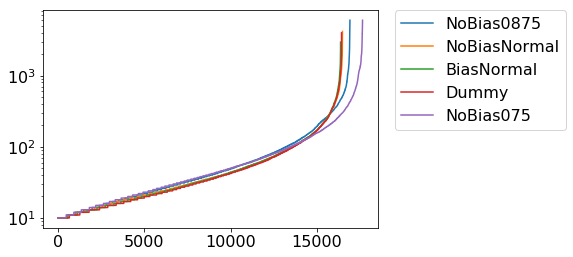

In [250]:
for key in failsDict.keys():
    data = sorted(list(map(lambda x: len(recipeUsers[x[0]]), failsDict[key])))
    plt.plot(data, label=key)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.yscale('log')
plt.show()

In [215]:
dfNoBias = pd.DataFrame(list(map(lambda x: len(recipeUsers[x[0]]), failsDict["NoBiasNormal"])))
dfBias = pd.DataFrame(list(map(lambda x: len(recipeUsers[x[0]]), failsDict["BiasNormal"])))
dfNoBias0875 = pd.DataFrame(list(map(lambda x: len(recipeUsers[x[0]]), failsDict["NoBias0875"])))
dfNoBias075 = pd.DataFrame(list(map(lambda x: len(recipeUsers[x[0]]), failsDict["NoBias075"])))
dfDummy = pd.DataFrame(list(map(lambda x: len(recipeUsers[x[0]]), failsDict["Dummy"])))

allInteractions = pd.DataFrame(list(map(lambda x: len(recipeUsers[x[0]]), interactions_te)))

In [ ]:
def compareFails(allInteractions, data, dataTitles, colors = ['r', 'b', 'g', 'y', 'purple']):

    data_fail_rate = []
    for i in range(len(data)):
        data_fail_rate.append([])
    
    ranges = [10, 30, 100, 500, 2000, 10000]
    
    for j in range(len(data)):
        totRecipes = len(allInteractions[0])
        failRecipes = len(data[j][0])
        data_fail_rate[j].append(failRecipes / totRecipes)
            
    for i in range(len(ranges)-1):
        totRecipes = sum(allInteractions[0].map(lambda x: 1 if x >= ranges[i] and x < ranges[i+1] else 0))

        for j in range(len(data)):
            failRecipes = sum(data[j][0].map(lambda x: 1 if x >= ranges[i] and x < ranges[i+1] else 0))
            data_fail_rate[j].append(failRecipes / totRecipes)
            
    N = len(data_fail_rate[0])

    ind = np.arange(N)  # the x locations for the groups
    width = 1 / (len(data) + 0.3)      # the width of the bars

    fig, ax = plt.subplots()
    fig.set_size_inches(16, 10)
    rects = []
    
    for i in range(len(data)):
        rects.append(ax.bar(ind + (i*width), data_fail_rate[i], width, color=colors[i]))

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Failure Rate')
    ax.set_xlabel('Recipe Popularity')
    ax.set_title('Failure Rate vs Recipe Popularity')
    ax.set_xticks(ind + 2 * width)
    xticks = ["Overall"]
    for i in range(len(ranges)-1):
        xticks.append(str(ranges[i]) + "-" + str(ranges[i+1]-1))
    ax.set_xticklabels(xticks)

    ax.legend(tuple(map(lambda x: x[0], rects)), dataTitles)


    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.0*height, '%.1f' % (100 * height) + "%",
                    ha='center', va='bottom', size=8)

    for rect in rects:
        autolabel(rect)

    plt.show()

In [257]:
def compareFailsRate(allInteractions, data, dataTitles, colors = ['r', 'b', 'g', 'y', 'purple']):

    data_fail_rate = []
    for i in range(len(data)):
        data_fail_rate.append([])
    
    ranges = [10, 30, 100, 500, 2000, 10000]
    
    '''
    for j in range(len(data)):
        totRecipes = len(allInteractions[0])
        failRecipes = len(data[j][0])
        data_fail_rate[j].append(failRecipes / totRecipes)
    '''
            
    for i in range(len(ranges)-1):

        for j in range(len(data)):
            totRecipes = len(data[j][0])
            failRecipes = sum(data[j][0].map(lambda x: 1 if x >= ranges[i] and x < ranges[i+1] else 0))
            data_fail_rate[j].append(failRecipes / totRecipes)
            
    N = len(data_fail_rate[0])

    ind = np.arange(N)  # the x locations for the groups
    width = 1 / (len(data) + 0.3)      # the width of the bars

    fig, ax = plt.subplots()
    fig.set_size_inches(16, 10)
    rects = []
    
    for i in range(len(data)):
        rects.append(ax.bar(ind + (i*width), data_fail_rate[i], width, color=colors[i]))

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Failure Rate')
    ax.set_xlabel('Recipe Popularity')
    ax.set_title('Failure Rate vs Recipe Popularity')
    ax.set_xticks(ind + 2 * width)
    xticks = []
    for i in range(len(ranges)-1):
        xticks.append(str(ranges[i]) + "-" + str(ranges[i+1]-1))
    ax.set_xticklabels(xticks)

    ax.legend(tuple(map(lambda x: x[0], rects)), dataTitles)


    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.0*height, '%.1f' % (100 * height) + "%",
                    ha='center', va='bottom', size=8)

    for rect in rects:
        autolabel(rect)

    plt.show()

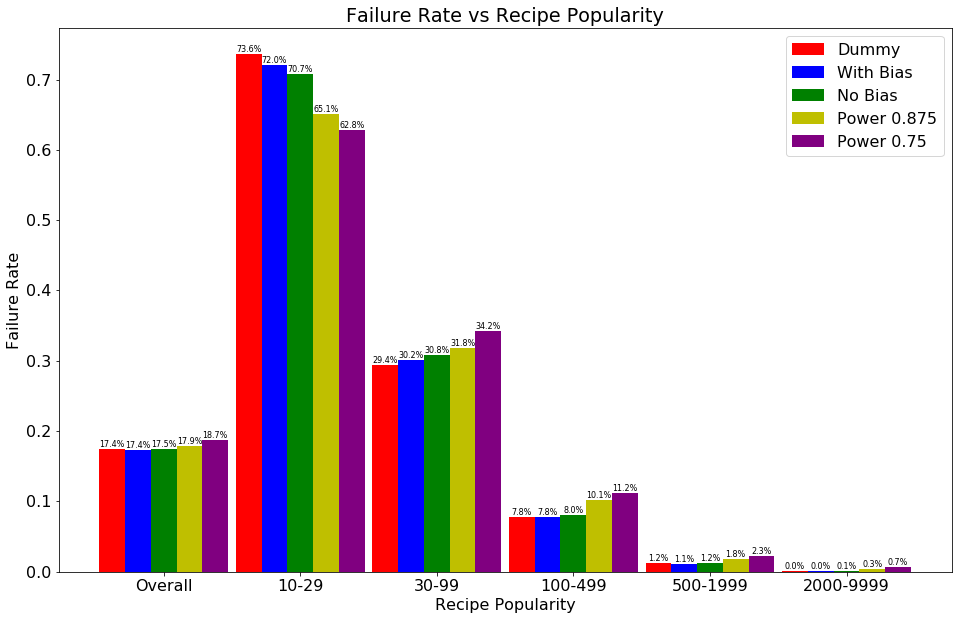

In [258]:
compareFails(allInteractions, [dfDummy, dfBias, dfNoBias, dfNoBias0875, dfNoBias075], ["Dummy", "With Bias", "No Bias", "Power 0.875", "Power 0.75"])

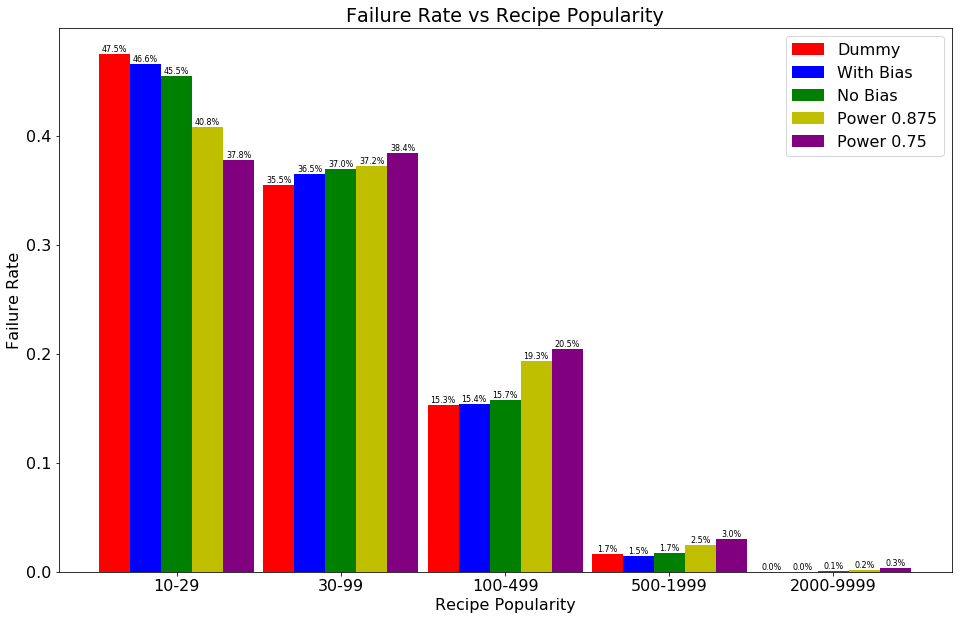

In [259]:
compareFailsRate(allInteractions, [dfDummy, dfBias, dfNoBias, dfNoBias0875, dfNoBias075], ["Dummy", "With Bias", "No Bias", "Power 0.875", "Power 0.75"])

## Cross validation

In [109]:
aucs = []
alphas = np.linspace(0.007, 0.013, 10)
for alpha in alphas:
    aucs.append(BPR(interactions_tr, interactions_te, False, alpha, 30, prob=False, _iter = 25*10**6)[1])

BPR with K: 30
Computing AUC...
AUC test: 0.4975928910756702
Computing AUC...
AUC test: 0.4962885985748218
Computing AUC...
AUC test: 0.4991728876823889
Computing AUC...
AUC test: 0.4994379877841873
Computing AUC...
AUC test: 0.5019299287410927
Computing AUC...
AUC test: 0.499660671869698
Computing AUC...
AUC test: 0.4996712758737699
Computing AUC...
AUC test: 0.5006680522565321
Computing AUC...
AUC test: 0.49902443162538174
Computing AUC...
AUC test: 0.49772013912453344
Computing AUC...
AUC test: 0.5006362402443163
Computing AUC...
AUC test: 0.5021844248388191
Computing AUC...
AUC test: 0.49880174753987105
Computing AUC...
AUC test: 0.498292755344418
Computing AUC...
AUC test: 0.49830335934849
Computing AUC...
AUC test: 0.49919409569053275
Computing AUC...
AUC test: 0.5004665761791652
Computing AUC...
AUC test: 0.5007953003053953
Computing AUC...
AUC test: 0.49987275195113673
Computing AUC...
AUC test: 0.5012618764845606
Computing AUC...
AUC test: 0.5013255005089922
Computing AUC...
A

KeyboardInterrupt: 

## Dummy Ranker

Evaluating the performance of a dummy ranker in order to compare it to the performance of our model. The dummy ranker simply rank recipes according to the number of reviews they have.

In [85]:
len(recipes)

26980

In [53]:
print("Computing AUC of dummy ranker...")
# Compute the Area Under the Curve (AUC)
auc = 0;
failsDummy = []
for interaction in interactions_te:
    recipe = interaction[0]
    user = interaction[1]
    n_recipe = sample_neg(recipes, user, userRecipes)

    sp = len(recipeUsers_tr[recipe])
    sn = len(recipeUsers_tr[n_recipe])

    if sp > sn:
        auc = auc+1
    else:
        failsDummy.append((recipe, n_recipe))
        if sp == sn:
            auc = auc+0.5

auc = auc / len(interactions_te)
print("AUC test: " + str(auc))

Computing AUC of dummy ranker...
AUC test: 0.838985746620175
